# # Imports and utility functions. 

The following section must be run.

In [316]:
import os

# baseFolder is the directory containing the folders full of datafiles.
baseFolder = os.getcwd()
# If defining a different baseFolder:
# baseFolder = user directory. 

# lateFolder is the folder where figures will be saved.
lateFolder = baseFolder + '/Figures/'

# If defining a different lateFolder:
# lateFolder = user directory. 

import numpy as np
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
#from matplotlib import rc
import pandas as pd
import scipy.io as sio
from scipy.integrate import quad
from collections import Counter
import statistics as st

# General Settings
labelFontSize = 16
padSize = 13
lineWidth = 4
alphaNum = .1


# Utility functions 
pi = np.pi
        
def MoI(x,time,D = 1, mu = 1):
    z = 1.0
    nom = 4*D*time
    mut = mu*time
    zed = mu*z/D
    j = (1/np.sqrt(pi*nom))*np.exp(-(x-mut)**2/nom) - np.exp(-(x-2*z-mut)**2/nom+zed) - np.exp(-(x+2*z-mut)**2/nom-zed)
    return j

def MoIMinus(x,time,D = 1, mu = -1):
    z = 1.0
    nom = 4*D*time
    mut = mu*time
    zed = mu*z/D
    j = (1/np.sqrt(pi*nom))*np.exp(-(x-mut)**2/nom) - np.exp(-(x-2*z-mut)**2/nom+zed) - np.exp(-(x+2*z-mut)**2/nom-zed)
    return j

def RpMoI(time,z, D = 1, mu = 1):
    
    rplus = quad(MoI,0,z,args = (time))
    rminus = quad(MoI,-z,0,args = (time))
    rp = np.log(rplus[0]/rminus[0])
    return rp

def MoIMulti(time,a,b,D=1,mu=1):
    rplus = quad(MoI,a,b,args = (time))
    rminus = quad(MoIMinus,a,b,args = (time))
    if rminus[0] == 0: return 0
    rp = np.log(rplus[0]/rminus[0])
    return rp

def basicPlot(x,ana,sim,simlow,simhigh,colori,labeli = None):
    plt.plot(x,ana,color = colori,label = labeli,linewidth = lineWidth)
    plt.plot(x,sim,'--',color = colori, label = None,linewidth = lineWidth)
    plt.plot(x,simlow,color = colori,alpha = alphaNum)
    plt.plot(x,simhigh,color = colori,alpha = alphaNum)
    plt.fill_between(x,simlow,simhigh,color = colori, alpha = alphaNum)
    plt.legend(frameon = False,fontsize = labelFontSize-2)

def superBasicPlot(x,ana,sim,colori,labeli = None):
    plt.plot(x,ana,color = colori,label = labeli,linewidth = lineWidth)
    plt.plot(x,sim,'--',color = colori, label = None,linewidth = lineWidth)
    plt.legend(frameon = False,fontsize = labelFontSize-2)
    
def getPk(folder,n,thmin,thmax = 1):
    folderName = folder + '/zMin_' + str(thmin).replace('.','_') + '_zMax_' + str(thmax).replace('.','_') + '/'
    
    fileName = folderName + 'Raw_n' + str(n) + '_batch_1.mat'
    #print('Pk: ' + fileName)
    batch = 1
    minP = 0; minM = 0; maxP = 0; maxM = 0; numReps = 0
    
    while (os.path.exists(fileName) and batch < 20):
        #print('Pk: ' + fileName)
        current = sio.loadmat(fileName)
        batchsize = int(current['batchSize'][0])
        Fds = current['FDI']
        agents = current['agents']
        for j in range(batchsize):
            fd = Fds[j]
            thFd = agents[j,0,abs(fd)-1]
            numReps = numReps + 1
            
            if fd > 0:
                if thFd == thmin: minP = minP + 1
                else: maxP = maxP + 1
            else:
                if abs(thFd) == thmin: minM = minM + 1
                else: maxM = maxM + 1
        
        
        batch = batch + 1
        fileName = folderName + 'Raw_n' + str(n) + '_batch_' + str(batch) + '.mat'    
    
    Ms = minM + maxM; Ps = minP + maxP
    minP = minP / Ps; minM = minM / Ms
    maxP = maxP / Ps; maxM = maxM / Ms
    
    return (minP,minM,maxP,maxM)

def getSims(folder, thMin,thMax,n,dichOmni):
    midFolder = folder + 'zMin_' + str(thMin).replace('.','_') + '_zMax_' + str(thMax).replace('.','_') + '/'
    allTimes = []; 
    allFirst = []; firstRight = []; firstWrong = []
    allRps = []; rpRight = []; rpWrong = []
    allIncs = []; incRight = []; incWrong = []
    fracAcc = []
    
    batch = 1
    fileName = midFolder + 'Raw_n' + str(n) + '_batch_' + str(batch) + '.mat'
    #print(fileName)
    while (os.path.exists(fileName) and batch < 35):
        #print('batch = ' + str(batch))
        current = sio.loadmat(fileName)
        t = current['times']
        batchSize = int(current['batchSize'][0])
        agents = current['agents']
        t = current['times']
        Fds = current['FDI']
        
        for j in range(batchSize):
            time = t[j][0]
            allTimes.append(time)
            rplus = RpMoI(time,thMin)
            ags = agents[j,2,:]
            jules = Counter(ags)
            plus = jules[1.0]
            minus = jules[-1.0]
            fd = Fds[j]
            
            if plus > 0:
                allFirst.append(plus); firstRight.append(plus)
                allRps.append(rplus); rpRight.append(rplus)
                incRight.append(rplus*(2*plus-n+1))
                fracAcc.append(1 + plus + jules[2.0])
                if dichOmni == True:
                    verne = Counter(agents[j,0,:])
                    cutoff = verne[thMin];thmin = thMin; thmax = thMax
                    jules1 = Counter(agents[j,2,0:cutoff-1])
                    plus1 = jules[1.0]; minus1 = jules[-1.0]
                    jules = Counter(agents[j,2,cutoff:-1])
                    plus2 = jules[1.0]; minus2 = jules[-1.0]
                    if abs(fd)  > cutoff:
                        rDec2 = MoIMulti(t[j],0,thmax); rUndec2 = MoIMulti(t[j],-thmax,0)
                        rDec1 = MoIMulti(t[j],max(thmin-thmax,-thmin),thmin); 
                        rUndec1 = MoIMulti(t[j],-thmin,max(thmin-thmax,-thmin))
                        update = rDec1*plus1 + rUndec1*(cutoff-plus1) + rDec2*plus2 + rUndec2*(n-cutoff-plus2-1)
                    else:
                        rDec1 = MoIMulti(t[j],0,thmin); rUndec1 = MoIMulti(t[j],-thmin,0)
                        rDec2 = MoIMulti(t[j],thmax-thmin,thmax); rUndec2 = MoIMulti(t[j],-thmax,thmax-thmin)
                        update = rDec1*plus1 + rUndec1*(cutoff-plus1-1) + rDec2*plus2 + rUndec2*(n-cutoff-plus2); 
                else:
                    update = rplus * (2*plus-n+1)
                allIncs.append(update)
                incRight.append(update)
                
            else: 
                allFirst.append(minus); firstWrong.append(minus)
                allRps.append(-rplus); rpWrong.append(-rplus)
                fracAcc.append(jules[2.0])
                if dichOmni == True:
                    verne = Counter(agents[j,0,:])
                    cutoff = verne[thMin]; thmin = thMin; thmax = thMax
                    jules1 = Counter(agents[j,2,0:cutoff-1])
                    plus1 = jules[1.0]; minus1 = jules[-1.0]
                    jules = Counter(agents[j,2,cutoff:-1])
                    plus2 = jules[1.0]; minus2 = jules[-1.0]
                    if abs(fd) > cutoff: 
                        rDec2 = MoIMulti(t[j],-thmax,0); rUndec2 = MoIMulti(t[j],0,thmax)
                        rDec1 = MoIMulti(t[j],-thmin,min(thmin,-thmin+thmax)); 
                        rUndec1 = MoIMulti(t[j],min(thmin,-thmin+thmax),thmin)
                        update = rDec1*minus1 + rUndec1*(cutoff-minus1) + rDec2*minus2 + rUndec2*(n-cutoff-minus2-1);
                    else:
                        rDec1 = MoIMulti(t[j],-thmin,0); rUndec1 = MoIMulti(t[j],0,thmin)
                        rDec2 = MoIMulti(t[j],-thmax,-thmax+thmin); rUndec2 = MoIMulti(t[j],-thmax+thmin,thmax)
                        update = rDec1*minus1 + rUndec1*(cutoff-minus1-1) + rDec2*minus2 + rUndec2*(n-cutoff-minus2)
                else:
                    update =  - rplus * (2*minus-n+1)
                allIncs.append(update); incWrong.append(update)
        
            
        
        batch = batch + 1
        fileName = midFolder + 'Raw_n' + str(n) + '_batch_' + str(batch) + '.mat'
    
    avgTime = st.mean(allTimes); varTime = st.variance(allTimes)
    avgFirst = st.mean(allFirst); varFirst = st.variance(allFirst)
    avgFirstFDA = st.mean(firstRight); varFirstFDA = st.variance(firstRight)
    avgFirstFDW = st.mean(firstWrong); varFirstFDW = st.variance(firstWrong)
    avgRp = st.mean(allRps); varRp = st.variance(allRps)
    avgRpFDA = st.mean(rpRight); varRpFDA = st.variance(rpRight)
    avgRpFDW = st.mean(rpWrong); varRpFDW = st.variance(rpWrong)
    avgInc = st.mean(allIncs); varInc = st.variance(allIncs)
    avgIncFDA = st.mean(incRight); varIncFDA = st.variance(incRight)
    avgIncFDW = st.mean(incWrong); varIncFDW = st.variance(incWrong)
    avgAcc = st.mean(fracAcc); varAcc = st.variance(fracAcc)
    return ((avgTime,varTime),
            (avgFirst,varFirst,avgFirstFDA,varFirstFDA,avgFirstFDW,varFirstFDW),
            (avgRp,varRp,avgRpFDA,varRpFDA,avgRpFDW,varRpFDW),
            (avgInc,varInc,avgIncFDA,varIncFDA,avgIncFDW,varIncFDW),
           (avgAcc, varAcc))




def makeDict(n_array,thetas,earlyFolder,thMax,shortN,isHom,isDoubled,dichOmni):
    timesVsN = []; lowTimesVsN = []; highTimesVsN = []; timeVarVsN = []
    firstWaveVsN = []; lowFirstWaveVsN = []; highFirstWaveVsN = []; firstWaveVarVsN = []
    firstWaveRVsN = []; lowFirstWaveRVsN = []; highFirstWaveRVsN = []; firstWaveRVarVsN = []
    firstWaveWVsN = []; lowFirstWaveWVsN = []; highFirstWaveWVsN = []; firstWaveWVarVsN = []
    rpVsN = []; lowRpVsN = []; highRpVsN = []; rpVarVsN = []
    rpRVsN = []; lowRpRVsN = []; highRpRVsN = []; rpRVarVsN = []
    rpWVsN = []; lowRpWVsN = []; highRpWVsN = []; rpWVarVsN = []
    incVsN = []; lowIncVsN = []; highIncVsN = []; incVarVsN = []
    incRVsN = []; lowIncRVsN = []; highIncRVsN = []; incRVarVsN = []
    incWVsN = []; lowIncWVsN = []; highIncWVsN = []; incWVarVsN = []
    accVsN = []; lowAccVsN = []; highAccVsN = []; accVarVsN = []
    shortNdict = {}
    for n in shortN:
        
        shortNdict[n] = {'times' : [], 'lowTimes' : [], 'highTimes' : [], 'timeVar' : [],
        'fw' : [], 'lowFw' : [], 'highFw' : [], 'fwVar' : [],
        'fwR': [], 'lowFwR' : [], 'highFwR' : [], 'fwRVar' : [],
        'fwW' : [], 'lowFwW' : [], 'highFwW' : [], 'fwWVar' : [],
        'rp' : [], 'lowRp' : [], 'highRp' : [], 'rpVar' : [],
        'rpR' : [], 'lowRpR' : [], 'highRpR' : [], 'rpRVar' : [],
        'rpW' : [], 'lowRpW' : [], 'highRpW' : [], 'rpWVar' : [],
        'inc' : [], 'lowInc' : [], 'highInc' : [], 'incVar' : [],
        'incR' : [], 'lowIncR' : [], 'highIncR' : [], 'incRVar' : [],
        'incW' : [], 'lowIncW' : [], 'highIncW' : [], 'incWVar' : [],
        'acc' : [], 'lowAcc':[], 'highAcc':[],'accVar': []}

    for th in thetas:
        first = True
        if isHom ==1:thMax = th
        times = []; lowTimes = []; highTimes = []; timeVar = []
        fw = []; lowFw = []; highFw = []; fwVar = []
        fwR = []; lowFwR = []; highFwR = []; fwRVar = []
        fwW = []; lowFwW = []; highFwW = []; fwWVar = []
        rp = []; lowRp = []; highRp = []; rpVar = []
        rpR = []; lowRpR = []; highRpR = []; rpRVar = []
        rpW = []; lowRpW = []; highRpW = []; rpWVar = []
        inc = []; lowInc = []; highInc = []; incVar = []
        incR = []; lowIncR = []; highIncR = []; incRVar = []
        incW = []; lowIncW = []; highIncW = []; incWVar = []
        acc = []; lowAcc = []; highAcc = []; accVar = []

        for n in n_array:
        
            mrg = getSims(earlyFolder,th,thMax,n,dichOmni)
            t = mrg[0]; f = mrg[1]; r = mrg[2]; i = mrg[3]; a = mrg[4]

            times.append(t[0]); tstd = np.sqrt(t[1]); timeVar.append(t[1])
            lowTimes.append(t[0]-tstd); highTimes.append(t[0]+tstd)
        
            fw.append(f[0]); fstd = np.sqrt(f[1]); 
            lowFw.append(f[0]-fstd); highFw.append(f[0]+fstd);fwVar.append(f[1])
            fwR.append(f[2]); fstd = np.sqrt(f[3]); fwRVar.append(f[3])
            lowFwR.append(f[2]-fstd); highFwR.append(f[2]+fstd)
            fwW.append(f[4]); fstd = np.sqrt(f[5]); fwWVar.append(f[5])
            lowFwW.append(f[4]-fstd); highFwW.append(f[4]+fstd)

            rp.append(r[0]); rstd = np.sqrt(r[1]); rpVar.append(r[1])
            lowRp.append(r[0]-rstd); highRp.append(r[0]+rstd)
            rpR.append(r[2]); rstd = np.sqrt(r[3]); rpRVar.append(r[3])
            lowRpR.append(r[2]-rstd); highRpR.append(r[2]+rstd)
            rpW.append(r[4]); rstd = np.sqrt(r[5]); rpWVar.append(r[5])

            inc.append(i[0]); istd = np.sqrt(i[1]); incVar.append(i[1])
            lowInc.append(i[0]-istd); highInc.append(i[0]+istd)
            incR.append(i[2]); istd = np.sqrt(i[3]); incRVar.append(i[3])
            lowIncR.append(i[2]-istd); highIncR.append(i[2]+istd)
            incW.append(i[4]); istd = np.sqrt(i[5]); incWVar.append(i[5])
            
            acc.append(a[0]); astd = np.sqrt(a[1]); accVar.append(a[1])
            lowAcc.append(a[0]-astd); highAcc.append(a[0]+astd)

            # For the vs th stuff
            if n in shortNdict: 
                if first or isDoubled ==0:
                    shortNdict[n]['times'].append(t[0]); tstd = np.sqrt(t[1]);
                    shortNdict[n]['timeVar'].append(t[1])
                    shortNdict[n]['lowTimes'].append(t[0]-tstd); shortNdict[n]['highTimes'].append(t[0]+tstd)

                    shortNdict[n]['fw'].append(f[0]); fstd = np.sqrt(f[1]); 
                    shortNdict[n]['lowFw'].append(f[0]-fstd); shortNdict[n]['highFw'].append(f[0]+fstd);
                    shortNdict[n]['fwVar'].append(f[1])
                    shortNdict[n]['fwR'].append(f[2]); fstd = np.sqrt(f[3]); shortNdict[n]['fwRVar'].append(f[3])
                    shortNdict[n]['lowFwR'].append(f[2]-fstd); shortNdict[n]['highFwR'].append(f[2]+fstd)
                    shortNdict[n]['fwW'].append(f[4]); fstd = np.sqrt(f[5]); shortNdict[n]['fwWVar'].append(f[5])
                    shortNdict[n]['lowFwW'].append(f[4]-fstd); shortNdict[n]['highFwW'].append(f[4]+fstd)

                    shortNdict[n]['rp'].append(r[0]); rstd = np.sqrt(r[1]); shortNdict[n]['rpVar'].append(r[1])
                    shortNdict[n]['lowRp'].append(r[0]-rstd); shortNdict[n]['highRp'].append(r[0]+rstd)
                    shortNdict[n]['rpR'].append(r[2]); rstd = np.sqrt(r[3]); shortNdict[n]['rpRVar'].append(r[3])
                    shortNdict[n]['lowRpR'].append(r[2]-rstd); shortNdict[n]['highRpR'].append(r[2]+rstd)
                    shortNdict[n]['rpW'].append(r[4]); rstd = np.sqrt(r[5]); shortNdict[n]['rpWVar'].append(r[5])

                    shortNdict[n]['inc'].append(i[0]); istd = np.sqrt(i[1]); shortNdict[n]['incVar'].append(i[1])
                    shortNdict[n]['lowInc'].append(i[0]-istd); shortNdict[n]['highInc'].append(i[0]+istd)
                    shortNdict[n]['incR'].append(i[2]); istd = np.sqrt(i[3]); shortNdict[n]['incRVar'].append(i[3])
                    shortNdict[n]['lowIncR'].append(i[2]-istd); shortNdict[n]['highIncR'].append(i[2]+istd)
                    shortNdict[n]['incW'].append(i[4]); istd = np.sqrt(i[5]); shortNdict[n]['incWVar'].append(i[5])
                    
                    shortNdict[n]['acc'].append(a[0]); astd = np.sqrt(a[1]); shortNdict[n]['accVar'].append(a[1])
                    shortNdict[n]['lowAcc'].append(a[0]-astd); shortNdict[n]['highAcc'].append(a[0]+astd)
                    first = False
                else: first = True
            
        timesVsN.append(times); lowTimesVsN.append(lowTimes); 
        highTimesVsN.append(highTimes); timeVarVsN.append(timeVar)
        firstWaveVsN.append(fw); lowFirstWaveVsN.append(lowFw); 
        highFirstWaveVsN.append(highFw); firstWaveVarVsN.append(fwVar)
        firstWaveRVsN.append(fwR); lowFirstWaveRVsN.append(lowFwR); 
        highFirstWaveRVsN.append(highFwR); firstWaveRVarVsN.append(fwRVar)
        firstWaveWVsN.append(fwW); lowFirstWaveWVsN.append(lowFwW); 
        highFirstWaveWVsN.append(highFwW); firstWaveWVarVsN.append(fwWVar)
        rpVsN.append(rp); lowRpVsN.append(lowRp); highRpVsN.append(highRp); rpVarVsN.append(rpVar)
        rpRVsN.append(rpR); lowRpRVsN.append(lowRpR); highRpRVsN.append(highRpR); rpRVarVsN.append(rpRVar)
        rpWVsN.append(rpW); lowRpWVsN.append(lowRpW); highRpWVsN.append(highRpW); rpWVarVsN.append(rpWVar)
        incVsN.append(inc); lowIncVsN.append(lowInc); highIncVsN.append(highInc); incVarVsN.append(incVar)
        incRVsN.append(incR); lowIncRVsN.append(lowIncR); highIncRVsN.append(highIncR); incRVarVsN.append(incRVar)
        incWVsN.append(incW); lowIncWVsN.append(lowIncW); highIncWVsN.append(highIncW); incWVarVsN.append(incWVar)
        accVsN.append(acc); lowAccVsN.append(lowAcc); highAccVsN.append(highAcc); accVarVsN.append(accVar)
    
    
    thisDict = {
        'ns' : n_array, 'shortN':shortN,
        'thetas': thetas,
        'thMax': thMax,
        'timesVsN': timesVsN,'lowTimesVsN':lowTimesVsN,'highTimesVsN':highTimesVsN,'timeVarVsN':timeVarVsN,
        'firstWaveVsN':firstWaveVsN,'lowFirstWaveVsN':lowFirstWaveVsN,
        'highFirstWaveVsN':highFirstWaveVsN,'firstWaveVarVsN':firstWaveVarVsN,
        'firstWaveRVsN':firstWaveRVsN,'lowFirstWaveRVsN':lowFirstWaveRVsN,
        'highFirstWaveRVsN':highFirstWaveRVsN,'firstWaveRVarVsN':firstWaveRVarVsN,
        'firstWaveWVsN':firstWaveWVsN,'lowFirstWaveWVsN':lowFirstWaveWVsN,
        'highFirstWaveWVsN':highFirstWaveWVsN,'firstWaveWVarVsN':firstWaveWVarVsN,
        'rpVsN':rpVsN,'lowRpVsN':lowRpVsN,'highRpVsN':highRpVsN,'rpVarVsN':rpVarVsN,
        'rpRVsN':rpRVsN,'lowRpRVsN':lowRpRVsN,'highRpRVsN':highRpRVsN,'rpRVarVsN':rpRVarVsN,
        'rpWVsN':rpWVsN,'lowRpWVsN':lowRpWVsN,'highRpWVsN':highRpWVsN,'rpWVarVsN':rpWVarVsN,
        'incVsN':incVsN,'lowIncVsN':lowIncVsN,'highIncVsN':highIncVsN,'incVarVsN':incVarVsN,
        'incRVsN':incRVsN,'lowIncRVsN':lowIncRVsN,'highIncRVsN':highIncRVsN,'incRVarVsN':incRVarVsN,
        'incWVsN':incWVsN,'lowIncWVsN':lowIncWVsN,'highIncWVsN':highIncWVsN,'incWVarVsN':incWVarVsN,
        'accVsN': accVsN, 'lowAccVsN': lowAccVsN, 'highAccVsN': highAccVsN,'accVarVsN': accVarVsN,
        'allVsTheta': shortNdict
    }
    return thisDict
    

# # Data Preparation

Of the following, only the needed sections for the desired figures need be run.

In [259]:
# Arrange Homogeneous Data. Needed for figures 1, 2, and 4, and supplemental figures 3 and 9.
n_array = (50,70,100,145,205,290,415,595,845,1200,1710,2435,3460,4935,7025,10000,15000,20000,50000)
thetas = (0.1,0.3,0.5,0.7,1); thMax = 1; isHom = 1; shortN = (10000,15000); isDoubled = 0;dichOmni = False
earlyFolder = baseFolder + '/SelfHomo_Paper/'
homDict = makeDict(n_array,thetas,earlyFolder,thMax,shortN,isHom,isDoubled,dichOmni)

In [271]:
# Arrange Dichotomous Consensus Bias Data for line graphs. Needed for figure 2, and
# supplemental figure 4
n_array = (15000,15000)
gammas = (.05,.3,.7)
thetas = (.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1)
thMax = 1; isHom = 0; shortN = (15000,15000); isDoubled = 1; dichOmni = False
earlyFolder = baseFolder + '/SelfDich/'

dichCBdicts = []
for gm in gammas:
    midFolder = earlyFolder + 'gamma_' + str(gm).replace('.','_') + '/'
    dichCBdicts.append(makeDict(n_array,thetas,midFolder,thMax,shortN,isHom,isDoubled,dichOmni))

In [317]:
# Arrange Dichotomous Omniscient Data for line graphs. Needed for supplemental figures 5 and 6
n_array = (15000,15000)
gammas = (.05,.3,.7)
thetas = (.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1)
thMax = 1; isHom = 0; shortN = (15000,15000); isDoubled = 1; dichOmni = True
earlyFolder = baseFolder + '/Dich/'

dichOmniDicts = []
for gm in gammas:
    midFolder = earlyFolder + 'gamma_' + str(gm).replace('.','_') + '/'
    dichOmniDicts.append(makeDict(n_array,thetas,midFolder,thMax,shortN,isHom,isDoubled,dichOmni))

C:\Users\Surface\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log
C:\Users\Surface\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in double_scalars


In [200]:
# Arrange Dichotomous Omniscient data for heat maps. Needed for figures 3 and 4, and supplemental figure 9

earlyFolder = baseFolder + '/Dich2Dense/'

folderName = earlyFolder + 'zMax_1_n15000/'
n = 15000

fileName = folderName + 'background.mat'
current = sio.loadmat(fileName)
gammas = current['gamma_array']
thmins = current['th_min_array']


data_Omni_Accs = np.zeros(shape = (len(thmins[0,:]),len(gammas[0,:])))
data_Omni_Decs = np.zeros(shape = (len(thmins[0,:]),len(gammas[0,:])))


for j in range(len(thmins[0,:])):
    # load file
    th = round(thmins[0,j],3)
    th_str = str(th)
    th_str = th_str.replace('.','_')
    fileName = folderName + 'zMin_' + th_str + '.mat'
    current = sio.loadmat(fileName)
    
    
    # retrieve accs
    accs = current['accs']

    for i in range(len(gammas[0,:])):
        data_Omni_Accs[i,j] = accs[i,0,0]/n
        data_Omni_Decs[i,j] = accs[i,0,1]/n
        
data_Omni_Accs = data_Omni_Accs[::-1]
data_Omni_Decs = data_Omni_Decs[::-1]

In [286]:
# Arrange Data for Uniform Consensus Bias Data. Needed for supplemental figure.

n_array = (5000,10000,15000)
thetas = (.05,.1,.2,.3,.4,.5,.7,.8,.9,1)
thetas = (.1,.2,.3,.5,.7,1)
thMax = 1; isHom = 0; shortN = (5000,10000,15000); isDoubled = 0; dichOmni = False

earlyFolder = baseFolder + '/SelfUniform/'
uniCBdict = makeDict(n_array,thetas,earlyFolder,thMax,shortN,isHom,isDoubled,dichOmni)

In [216]:
# Arrange Data for Uniform Omniscient Data. Needed for figure 4 and supplemental figure 9
# Note: the calculation for social increment in the utility function is not geared for this case. 
# Please do not use it for comparisons; it does not match the actual update used in the simulations.
# All other data arranged by the utility function for this case is accurate.

n_array = (15000,15000)
thetas = (.05,.1,.2,.3,.4,.5,.7,.8,.9,1)
thMax = 1; isHom = 0; shortN = (15000,15000); isDoubled = 1; dichOmni = False
earlyFolder = baseFolder + '/Uniform/'
uniDict = makeDict(n_array,thetas,earlyFolder,thMax,shortN,isHom,isDoubled,dichOmni)

In [278]:
# Arrange Data for Inclined Shed Omniscient. Needed for supplemental figure 9
# Note: the calculation for social increment in the utility function is not geared for this case. 
# Please do not use it for comparisons; it does not match the actual update used in the simulations.
# All other data arranged by the utility function for this case is accurate.

n_array = (15000,15000)
thetas = (.05,.1,.2,.3,.4,.5,.7,.8,.9,1)
thMax = 1; isHom = 0; shortN = (15000,15000); isDoubled = 1; dichOmni = False
earlyFolder = baseFolder + '/Shed/Div_1/'
incShedDict = makeDict(n_array,thetas,earlyFolder,thMax,shortN,isHom,isDoubled, dichOmni)

In [279]:
# Arrange Data for Declined Shed Omniscient. Needed for supplemental figure 9
# Note: the calculation for social increment in the utility function is not geared for this case. 
# Please do not use it for comparisons; it does not match the actual update used in the simulations.
# All other data arranged by the utility function for this case is accurate.

n_array = (15000,15000)
thetas = (.05,.1,.2,.3,.4,.5,.7,.8,.9,1)
thMax = 1; isHom = 0; shortN = (15000,15000); isDoubled = 1; dichOmni = False
earlyFolder = baseFolder + '/Shed/Div_2/'
decShedDict = makeDict(n_array,thetas,earlyFolder,thMax,shortN,isHom,isDoubled,dichOmni)

In [280]:
# Arrange Data for Tent Omniscient. Needed for supplemental figure 9
# Note: the calculation for social increment in the utility function is not geared for this case. 
# Please do not use it for comparisons; it does not match the actual update used in the simulations.
# All other data arranged by the utility function for this case is accurate.

n_array = (15000,15000)
thetas = (.05,.1,.2,.3,.4,.5,.7,.8,.9,1)
thMax = 1; isHom = 0; shortN = (15000,15000); isDoubled = 1; dichOmni = False
earlyFolder = baseFolder + '/Tent/'
tentDict = makeDict(n_array,thetas,earlyFolder,thMax,shortN,isHom,isDoubled,dichOmni)

## Main Paper Figures

## Figure 1

Figure 1, Panel d -- requires: homogeneous data
Plots the actual size of the first wave and the size of the first wave as a fraction of agents remaining after the first decision for accurate first decisions in homogeneous cliques with threshold theta = 0.7 as a function of clique size n.

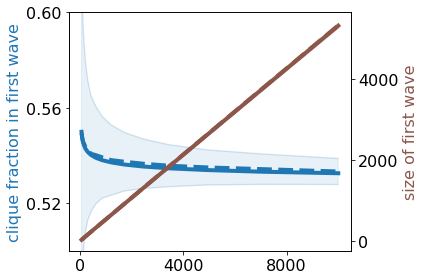

In [127]:


# Set index for th = 0.7
thId = 3; th = 0.7; 

# Retrieve Data
n_array = homDict['ns'][0:-3]; 
fw = homDict['firstWaveRVsN'][thId][0:-3]; 
fwLow = homDict['lowFirstWaveRVsN'][thId][0:-3]; fwHigh = homDict['highFirstWaveRVsN'][thId][0:-3]

frac_first = []; frac_first_low = []; frac_first_high = [];
for i in range(len(n_array)):
    n = n_array[i]
    frac_first.append(fw[i]/(n-1)); frac_first_low.append(fwLow[i]/(n-1)); frac_first_high.append(fwHigh[i]/(n-1))

# Analytic results
anal_first = [((N-1)/2)*(1 + th/np.sqrt(4*np.pi*np.log(N))) for N in n_array]
frac_first_anal = [((1/2)*(1 + th/np.sqrt(4*np.pi*np.log(N)))) for N in n_array]

colors = sns.color_palette("tab10")

color1 = colors[0]
color2 = colors[5]

# Create plot
fig3, ax4 = plt.subplots()
    
ax4.plot(n_array, frac_first, '--',color = color1, linewidth = lineWidth)
ax4.plot(n_array, frac_first_high, color = color1, alpha = alphaNum)
ax4.plot(n_array,frac_first_low,color = color1, alpha = alphaNum)
ax4.fill_between(n_array,frac_first_low,frac_first_high, color = color1, alpha = alphaNum)
ax4.plot(n_array, frac_first_anal, color = color1, linewidth = lineWidth)
                        
ax4.set_ylabel('clique fraction in first wave', color = color1, fontsize = labelFontSize)
ax4.set_ylim(bottom = 0, top = 5500)
ax4.yaxis.set_major_locator(plt.MaxNLocator(3))
ax4.xaxis.set_major_locator(plt.MaxNLocator(3))
ax4.set_ylim(bottom = 0.5, top = 0.6)
plt.xticks(fontsize = labelFontSize)
plt.yticks(fontsize = labelFontSize)


ax5 = ax4.twinx()
ax5.plot(n_array, fw, '--', color = color2, linewidth = lineWidth)
ax5.plot(n_array, fwHigh, color = color2, alpha = alphaNum)
ax5.plot(n_array, fwLow, color = color2, alpha = alphaNum)
ax5.fill_between(n_array, fwLow, fwHigh, color = color2, alpha = alphaNum)

ax5.plot(n_array, anal_first, color = color2, linewidth = lineWidth)
ax5.set_ylabel('size of first wave', color = color2, fontsize = labelFontSize)

ax5.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.yticks(fontsize = labelFontSize)

plt.tight_layout()
saveName = lateFolder + 'firstWaves_th_0_7.png'
plt.savefig(saveName,dpi = 300)
saveName = lateFolder + 'firstWaves_th_0_7.pdf'
plt.savefig(saveName,dpi = 300)

Figure 1, Panel e -- requires: homogeneous data
Plots the expected first decision time and the magnitidue of the expected social information made available by a single agent as a function of clique size n for a homogeneous clique with threshold theta = 0.7. 

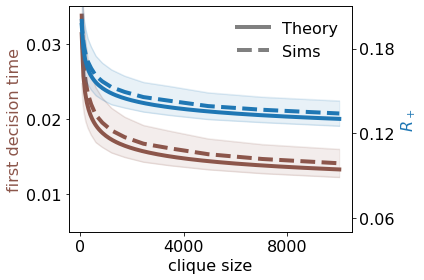

In [131]:
# Set index for th = 0.7
thId = 3; th = 0.7; 

# Retrieve data
n_array = homDict['ns'][0:-3]
avgTimes = homDict['timesVsN'][thId][0:-3]; 
times_low = homDict['lowTimesVsN'][thId][0:-3]; times_high = homDict['highTimesVsN'][thId][0:-3]
rps = homDict['rpRVsN'][thId][0:-3]; 
rps_low = homDict['lowRpRVsN'][thId][0:-3]; rps_high = homDict['highRpRVsN'][thId][0:-3]

# Analytic results
ns = np.linspace(50,10000,num = 150)
times = [(th**2)/(4*np.log(n)) for n in ns]
Rp = [RpMoI(t,th) for t in times]

# Plot

colors = sns.color_palette("tab10")

color1 = colors[0]
color2 = colors[5]

fig4, ax6 = plt.subplots()

ax6.plot(n_array, avgTimes, '--', color = color2, linewidth = lineWidth)
ax6.plot(n_array, times_low, color = color2, alpha = alphaNum)
ax6.plot(n_array, times_high, color = color2, alpha = alphaNum)
ax6.fill_between(n_array, times_low, times_high, color = color2, alpha = alphaNum)
ax6.plot(ns, times, color = color2, linewidth = lineWidth)
sims = [.4 for n in n_array]; theory = [-.4 for n in n_array]
ax6.plot(n_array,theory,color = 'gray', linewidth = lineWidth, label = 'Theory')
ax6.plot(n_array,sims,'--',color = 'gray', linewidth = lineWidth, label = 'Sims')
ax6.set_ylabel('first decision time', color = color2, fontsize = labelFontSize)
ax6.yaxis.set_major_locator(plt.MaxNLocator(3))
ax6.xaxis.set_major_locator(plt.MaxNLocator(3))
plt.legend(frameon = False, fontsize = labelFontSize)
plt.xticks(fontsize = labelFontSize)
plt.yticks(ticks = [.01,.02,.03],fontsize = labelFontSize)
plt.ylim(.005,.035)
#ax6.set_xscale('log')
ax6.set_xlabel('clique size', fontsize = labelFontSize)
plt.xlabel('clique size', fontsize = labelFontSize)
plt.ylabel('first decision time', fontsize = labelFontSize)
ax = plt.gca()

ax5 = ax6.twinx()
ax5.plot(n_array, rps, '--', color = color1, linewidth = lineWidth)
ax5.plot(n_array, rps_low, color = color1, alpha = alphaNum)
ax5.plot(n_array, rps_high, color = color1, alpha = alphaNum)
ax5.fill_between(n_array, rps_low, rps_high, color = color1, alpha = alphaNum)
ax5.plot(ns, Rp, color = color1 ,linewidth = lineWidth)

ax5.set_ylabel(r'$R_+$', color = color1, fontsize = labelFontSize)
plt.yticks(fontsize = labelFontSize)
plt.ylabel(r'$R_+$',fontsize = labelFontSize)
ax5.yaxis.set_major_locator(plt.MaxNLocator(3))
ax5.set_ylim(.05,.21)

plt.tight_layout()
saveName = lateFolder + 'times_and_rp.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + 'times_and_rp.pdf'
plt.savefig(saveName, dpi = 300)

## Figure 2

Figure 2, Panel a -- requires: homogeneous data
Plots the expected size of the social increment after the first wave (second wave increment) as a function of clique size n for homogeneous cliques with thresholds theta = 0.3, 0.5, and 1.0. 

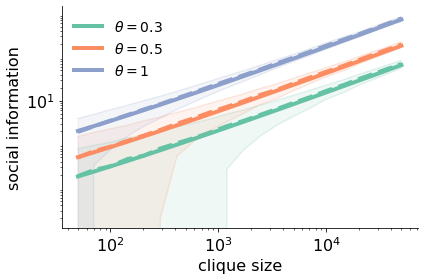

In [135]:

# local analytic function

def findC(n, th = 0.1):
    c = ((th**2)*n)/(2*pi*np.log(n))
    return c


# Retreive data and plot
n_list = homDict['ns']
th_list = (0.3,0.5,1); thId_list = (1,2,4)
colors = sns.color_palette("Set2", 10)

for i in range(len(th_list)):
    th = thId_list[i]
    # label
    labe = r'$\theta =$' + str(th_list[i])
    # Analytic result
    approxC = [findC(n, th = th_list[i]) for n in n_list]
    
    simC = homDict['incRVsN'][th]; simC_low = homDict['lowIncRVsN'][th]; simC_high = homDict['highIncRVsN'][th]
    
    basicPlot(n_list,approxC,simC,simC_low,simC_high,colori = colors[i],labeli = labe)

        
plt.ylabel('second wave increment', fontsize = labelFontSize)
plt.xlabel('clique size', fontsize = labelFontSize)
plt.xscale('log')
plt.yscale('log')
ax.yaxis.set_major_locator(plt.MaxNLocator(3))

plt.xticks(fontsize = labelFontSize)
plt.yticks(ticks = [10],fontsize = labelFontSize)
plt.tight_layout()
sns.despine()
lateFolder = 'C:/Users/Surface/OneDrive/Documents/thought bubbles/Figures for paper/Figure 2/'

saveName = lateFolder + 'socialAfterFirstvsCliqueSize.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + 'socialAfterFirstvsCliqueSize.pdf'
plt.savefig(saveName, dpi = 300)

Figure 2, Panel b -- requires: homogeneous data
Plots the fraction of trials in for which there is an analytic guarantee the entire clique will decide by the end of the second wave as a function of clique size n for homogeneous cliques with thresholds theta = 0.3, 0.5, and 1.0. 

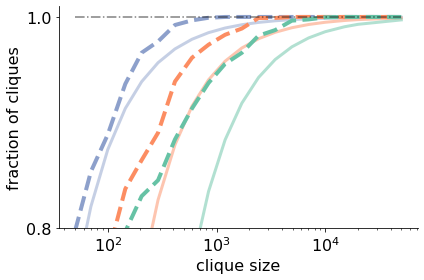

In [142]:
# Local utility functions

def fracGuaranteed(n,th):
    frac = 1-4*np.pi/(th**2*n)
    return frac

def percentDecided(folder, n,th):
    midFolder = folder + '/zMin_' + str(th).replace('.','_') + '_zMax_' + str(th).replace('.','_') + '/'
    numReps = 0; numAllDecided = 0;
    batch = 1
    fileName = midFolder + 'Raw_n' + str(n) + '_batch_' + str(batch) + '.mat'

    while (os.path.exists(fileName) and batch < 40):

        current = sio.loadmat(fileName)

        batchSize = int(current['batchSize'][0])
        agents = current['agents']
        
        for j in range(batchSize):
            ags = agents[j,2,:]
            jules = Counter(ags)
            numUnDec = jules[0.0]
            
            numReps = numReps + 1
            if numUnDec < 2: numAllDecided = numAllDecided + 1
        
            
        
        batch = batch + 1
        fileName = midFolder + 'Raw_n' + str(n) + '_batch_' + str(batch) + '.mat'
    

    return numAllDecided/numReps


# Retrieve and generate data and plot
folder = baseFolder + 'SelfHomo_Paper'

n_array = homDict['ns']; th_array = homDict['thetas']

thIds = (4,2,1)
i = 2
for thId in thIds:
    th = th_array[thId]
    perDec = [percentDecided(folder, n, th) for n in n_array]
    guaranFrac = [fracGuaranteed(n, th) for n in n_array]

    plt.plot(n_array, perDec,'--',color = colors[i],label = None, linewidth = lineWidth)
    plt.plot(n_array,guaranFrac,color = colors[i], label =r'$\theta = $' + str(th) ,linewidth = lineWidth-1, alpha = .5)

    i = i-1

plt.legend(frameon = False, fontsize = labelFontSize-2)
oneLine = [1 for n in n_array]
plt.plot(n_array, oneLine, linestyle = 'dashdot', color = 'black', alpha = .5)

plt.xscale('log')
plt.xlabel('clique size', fontsize = labelFontSize)#,labelpad = padSize)
plt.ylabel('probability whole \n clique decides', fontsize = labelFontSize)#, labelpad = padSize)
plt.ylim(.8,1.01)

plt.xticks(fontsize = labelFontSize)
plt.yticks(ticks = [.8,1],fontsize = labelFontSize)

plt.tight_layout()
sns.despine()
saveName = lateFolder + 'perDec_by_Second.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + 'perDec_by_Second.pdf'
plt.savefig(saveName, dpi = 300)

Figure 2, Panel b inset -- requires: homogeneous data
Plots the threshold needed to guarantee that in 95% of trials, the entire clique will have decided by the end of the second wave as a function of clique size n. As n increases, a smaller threshold is required to secure this guarantee.

C:\Users\Surface\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:90: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
C:\Users\Surface\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
C:\Users\Surface\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:96: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
C:\Users\Surface\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  fig.canvas.print_figure(bytes_io, **kw)


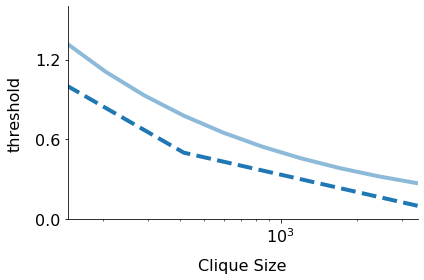

In [151]:
# local utility functions

def percentDecided(folder, n,th):
    midFolder = folder + '/zMin_' + str(th).replace('.','_') + '_zMax_' + str(th).replace('.','_') + '/'
    numReps = 0; numAllDecided = 0;
    batch = 1
    fileName = midFolder + 'Raw_n' + str(n) + '_batch_' + str(batch) + '.mat'
 
    while (os.path.exists(fileName) and batch < 40):

        current = sio.loadmat(fileName)

        batchSize = int(current['batchSize'][0])
        agents = current['agents']
        
        for j in range(batchSize):
            ags = agents[j,2,:]
            jules = Counter(ags)
            numUnDec = jules[0.0]
            
            numReps = numReps + 1
            if numUnDec < 2: numAllDecided = numAllDecided + 1
        
            
        
        batch = batch + 1
        fileName = midFolder + 'Raw_n' + str(n) + '_batch_' + str(batch) + '.mat'
    

    return numAllDecided/numReps



def findClosestN(n_array, th,  folderName,findPer = .95):
    
    #findPer = .97
    found = False
    oldPer = 0
    for i in range(len(n_array)):
        n = n_array[i]
        per = percentDecided(folderName, n,th)
        #print(per)    
        if per > findPer:
            found = True
            if abs(per-findPer) < abs(oldPer - findPer):
                closest = n
            else:
                closest = n_array[i-1]
        else:
            i = i + 1
            oldPer = per
            
        if i == len(n_array):
            found = True
            closest = 0
        if found == True: break
            
    return closest
            

# create data

n_array = (50,70,100,145,205,290,415,595,845,1200,1710,2435,3460,4935,7025,10000)

minThs = [np.sqrt((80*np.pi)/n) for n in n_array]

otherColors = sns.color_palette("tab10")
color1 = otherColors[0]; color2 = otherColors[5]
th_list = (.1,0.3,0.5,1)
folder = baseFolder + 'SelfHomo_Paper/'
ninetyFives = []
for th in th_list:
    ninetyFives.append(findClosestN(n_array,th,folder,findPer = .95))

    

# plot
fig, ax = plt.subplots()
plt.plot(ninetyFives, th_list, '--', color = color1, label = '95%', linewidth = lineWidth)
plt.plot(n_array, minThs, color = color1,linewidth = lineWidth, alpha = .5)

plt.xlabel('clique size', labelpad = padSize, fontsize = labelFontSize)
plt.ylabel('threshold', fontSize = labelFontSize, labelpad = padSize)# rotation = 0)
plt.xscale('log')

ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.xlim(min(ninetyFives),max(ninetyFives))
plt.xticks(fontsize = labelFontSize)
plt.yticks(fontsize = labelFontSize)
plt.ylim(0,1.6)
ax = plt.gca()
#sets the ratio to 5
ax.set_aspect(2)
plt.tight_layout()
sns.despine()

saveName = lateFolder + '/ninetyFivePercentofCliquesChoosevsTheta.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + '/ninetyFivePercentofCliquesChoosevsTheta.pdf'
plt.savefig(saveName, dpi = 300)

Figure 2, Panel c -- requires: dichotomous consensus bias data
Plots expected first decision time as a function of thetaMin for dichotomous consensus bias cliques with small theta fraction gamma at 0.05, 0.3, and 0.7 for a clique of 15000 agents.

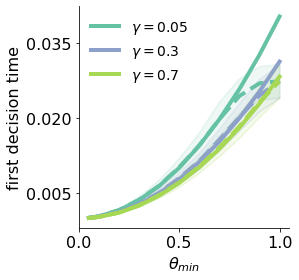

In [162]:
# local analytic function
def time(thmin, n, gamma):
    t = thmin**2/(4*np.log(gamma*n))
    return t

# Retrieve data and plot
colors2 = sns.color_palette("Set2")
gammas = (.05,.3,.7); n = 15000

for i in range(len(gammas)):
    gamma = gammas[i]
    gammaLabel = r'$\gamma = $' + str(gamma)
    mrg = dichCBdicts[i]   
    thetas = mrg['thetas']
    anaTimes = [time(th,n,gamma) for th in thetas]

    simT = mrg['allVsTheta'][15000]['times']
    simTLow = mrg['allVsTheta'][15000]['lowTimes']; simTHigh = mrg['allVsTheta'][15000]['highTimes']
    
    basicPlot(thetas, anaTimes, simT, simTLow, simTHigh, colori = colors2[i*2], labeli = gammaLabel)
    

plt.legend(frameon = False, fontsize = labelFontSize -2)
plt.xlabel(r'$\theta_{min}$', fontsize = labelFontSize)
plt.ylabel('first decision time', fontsize = labelFontSize)
plt.xticks(ticks = [0,.5,1],fontsize = labelFontSize)
plt.yticks(ticks = [0,.035],fontsize = labelFontSize)
ax = plt.gca()
ax.set_aspect(25)
plt.tight_layout()

sns.despine()

saveName = lateFolder + "expectedFDT_DichCB.png"
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + "expectedFDT_DichCB.pdf"
plt.savefig(saveName, dpi = 300)

Figure 2, Panel d -- requires: dichotomous consensus bias data
Plots number of accurate deciders over total clique size as a function of thetaMin for dichotomous consensus bias cliques with small theta fraction gamma at 0.05, 0.3, and 0.7 for a clique of 15000 agents.

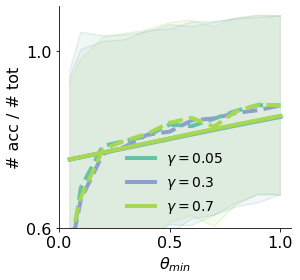

In [318]:
# local analytic function
def fracAcc(th,n,gamma):
    n = n*gamma
    frac = (1+np.exp(-th))**(-1) + np.exp(-th)*(n-1)*(1-th/np.sqrt(4*np.pi*np.log(n)))/(2*n*(1+np.exp(-th)))
    return frac

gammas = (0.05,0.3,0.7); n = 15000
colors = sns.color_palette("Set2")

# Retrieve data and plot

for i in range(len(gammas)):
    gamma = gammas[i]
    mrg = dichCBdicts[i]
    thetas = mrg['thetas']
    gammaLabel = r'$\gamma = $' + str(gamma)
    anaFracs = [fracAcc(th,n,gamma) for th in thetas]
    
    simA = [f/n for f in mrg['allVsTheta'][15000]['acc']]; 
    simALow = [f/n for f in mrg['allVsTheta'][15000]['lowAcc']];
    simAHigh = [f/n for f in mrg['allVsTheta'][15000]['highAcc']]
        
    basicPlot(thetas, anaFracs, simA, simALow, simAHigh, colori = colors[i*2], labeli = gammaLabel)
    
    

plt.legend(frameon = False, fontsize = labelFontSize -2)
plt.xlabel(r'$\theta_{min}$', fontsize = labelFontSize)
plt.ylabel('# acc / # tot', fontsize = labelFontSize)
plt.xticks(ticks = [0,.5,1],fontsize = labelFontSize)
plt.yticks(ticks = [.6,1],fontsize = labelFontSize)
plt.ylim(.6,1.1)
ax = plt.gca()
ax.set_aspect(2)
plt.tight_layout()
sns.despine()

saveName = lateFolder + "fracAccDichCB.png"
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + "fracAccDichCB.pdf"
plt.savefig(saveName, dpi = 300)

Figure 2, Panel e -- requires: dichotomous consensus bias data
Plots the amount of social information available after the first wave, which causes the second wave, as a function of thetaMin for dichotomous consensus bias cliques with small theta fraction gamma at 0.05, 0.3, and 0.7 for a clique of 15000 agents.

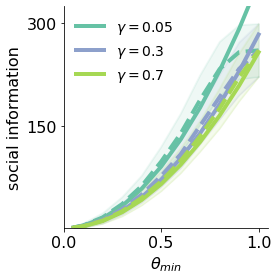

In [170]:
# local analytic function
def getAnaC(thMin,n,gamma,thMax = 1):
    c = (thMin**2*n)/(2*pi*np.log(gamma*n))
    return c


# Retrieve data and plot
gammas = (0.05,0.3,0.7); n = 15000
colors = sns.color_palette("Set2")
for i in range(len(gammas)):
    gamma = gammas[i]
    mrg = dichCBdicts[i]
    thetas = mrg['thetas']
    gammaLabel = r'$\gamma = $' + str(gamma)
    anaC = [getAnaC(th,n,gamma) for th in thetas]
    
    simC = mrg['allVsTheta'][n]['inc']; simCLow = mrg['allVsTheta'][n]['lowInc']; simCHigh = mrg['allVsTheta'][n]['highInc']
        
    basicPlot(thetas, anaC, simC, simCLow, simCHigh, colori = colors[i*2], labeli = gammaLabel)

    
plt.legend(frameon = False, fontsize = labelFontSize -2)
plt.xlabel(r'$\theta_{min}$', fontsize = labelFontSize)
plt.ylabel('social information', fontsize = labelFontSize)
plt.xticks(ticks = [0,.5,1],fontsize = labelFontSize)
plt.yticks(ticks = [150,300],fontsize = labelFontSize)
plt.ylim(0,325)
ax = plt.gca()
ax.set_aspect(.0035)
#plt.yscale('log')
plt.tight_layout()
sns.despine()

saveName = lateFolder + "expectedCdichCB.png"
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + "expectedCdichCB.pdf"
plt.savefig(saveName, dpi = 300)

## Figure 3

Figure 3, Panel d -- requires: dichotomous omniscient data for heat maps
Shows heatmap of number of agents making an accurate decision divided by total number of agents for a fixed size dichotomous omniscient clique with 15000 agents. Include contour line marking the point at which the expected second wave increment is 2 thetaMax and a star that marks the point of maximum accuracy.

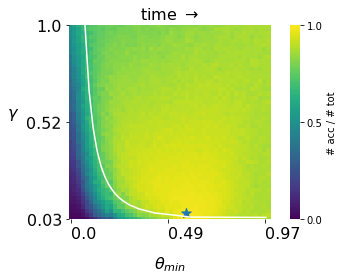

In [208]:

# Get analytic expression for social increment ~ 2 thetaMax
def fracC(th_min,gamma,N,th_max = 1):
    frac = (4*np.pi*th_max*np.log(N))/(gamma*N*th_min**2)
    return frac

size = 50
time_gammas = np.linspace(.991,.001,num = size)
thetas = np.linspace(.01,1,num = size)
N = 15000

data_C = np.zeros(shape = (size,size))

for j in range(size):
    th_min = thetas[j]
    for i in range(size):
        gamma = time_gammas[i]
        data_C[i,j] = fracC(th_min,gamma,N)



# This sets the aspect ratio
plt.imshow(data_Omni_Accs,
           cmap='cubehelix',
           extent = (0,1,0,1))
           

# Round the numbers used for axis labels
roundNum = 2

thetas = np.linspace(1,.01,num = size)

for i in range(size):
    thetas[i] = round(thetas[i], roundNum)
    time_gammas[i] = round(time_gammas[i],roundNum)
    

time_gammas = time_gammas[::-1]

# Create heatmap
df = pd.DataFrame(data_Omni_Accs,index = thetas, columns = time_gammas)

heat_map = sns.heatmap(df ,cmap = sns.color_palette('viridis',120),
                      vmin = 0, vmax = 1,
                      xticklabels = 24, yticklabels = 24,
                      cbar_kws={'label':'# acc / # tot',
                                'ticks':[0.,0.5,1]})
heat_map.tick_params(axis='x', top=False, labeltop=False, labelbottom=True, direction='out', labelsize = labelFontSize)
heat_map.tick_params(axis = 'y', direction = 'out', labelrotation = .5, labelsize = labelFontSize)

ticklbls = heat_map.get_xticklabels(which='both')

for x in ticklbls:
    x.set_ha('left') 


    
# Add contour for expected social increment = 2 thetaMax line
levels = [.001,1]
import matplotlib.cm as cm
ct=plt.contour(data_C,levels, cmap = cm.gray) 

# Mark point of maximum accuracy
loc = np.where(data_Omni_Accs == np.amax(data_Omni_Accs))
plt.scatter(loc[1],loc[0], marker = '*', s = 100)
plt.xlabel(r'$\theta_{min}$', labelpad = 13,rotation = 0, fontsize = labelFontSize)
plt.ylabel(r'$\gamma$', labelpad = 13,rotation = 0, fontsize = labelFontSize)
plt.title('time ' + r'$\rightarrow$', fontsize = labelFontSize)
plt.tight_layout()
plt.show


saveName = lateFolder + '/HeatmapDichOmni_Accs.png'
plt.savefig(saveName,dpi = 300)
saveName = lateFolder + '/HeatmapDichOmni_Accs.pdf'
plt.savefig(saveName,dpi = 300)

Figure 3, Panel e -- requires: dichotomous omniscient data for heat maps
Shows heatmap of number of agents making a decision divided by total number of agents for a fixed size dichotomous omniscient clique with 15000 agents. Include contour lines for analytically obtained first decision times and a star that marks the point of maximum accuracy (number of agents deciding accurately divided by total number of agents).

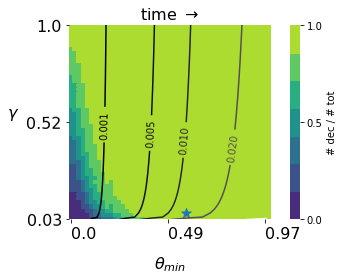

In [207]:
# local utility and analytic functions

def FDT(th_min, gamma, N):
    j = (th_min**2)/(4*np.log(gamma*N))
    return j

size = 50
time_gammas = np.linspace(.991,.001,num = size)
thetas = np.linspace(.01,1,num = size)

N = 15000

data_FDT = np.zeros(shape = (size,size))

# Get analytic version of first decision times; used for contours
for j in range(size):
    th_min = thetas[j]
    for i in range(size):
        gamma = time_gammas[i]
        data_FDT[i,j] = FDT(th_min,gamma,N)



# This might seem redundant, but including it changes 
# the aspect ratio. 
plt.imshow(data_Omni_AccDecs,
           cmap='cubehelix',
           extent = (0,1,0,1))

# Round numbers used in axis labels
roundNum = 2
for i in range(size):
    thetas[i] = round(thetas[i],roundNum)
    time_gammas[i] = round(time_gammas[i],roundNum)
    
thetas = thetas[::-1]
time_gammas = time_gammas[::-1]

# Create heatmap
df = pd.DataFrame(data_Omni_Decs,index = thetas, columns = time_gammas)
 

heat_map = sns.heatmap(df ,cmap = sns.color_palette('viridis',7),
                      vmin = 0, vmax = 1,
                      xticklabels = 24, yticklabels = 24,
                      cbar_kws={'label':'# dec / # tot',
                                'ticks':[0,.5,1]})
heat_map.tick_params(axis='x', top=False, labeltop=False, labelbottom=True, direction='out', labelsize = labelFontSize)
heat_map.tick_params(axis = 'y', direction = 'out', labelrotation = .5, labelsize = labelFontSize)

ticklbls = heat_map.get_xticklabels(which='both')

for x in ticklbls:
    x.set_ha('left') 
    
# Add contours for first decision time
levels=[.001,.005,.01,.02,.06]
labelLocation = [(5,25),(17,27),(30,29),(35,30)]

import matplotlib.cm as cm
ct=plt.contour(data_FDT,levels, cmap = cm.gray) 
plt.clabel(ct,fmt='%2.3f', manual = labelLocation)

# Mark location with maximum accuracy
loc = np.where(data_Omni_Accs == np.amax(data_Omni_Accs))
plt.scatter(loc[1],loc[0], marker = '*', s = 100)


plt.xlabel(r'$\theta_{min}$', labelpad = 13,rotation = 0, fontsize = labelFontSize)
plt.ylabel(r'$\gamma$', labelpad = 13,rotation = 0, fontsize = labelFontSize)
plt.title('time ' + r'$\rightarrow$', fontsize = labelFontSize)
plt.tight_layout()
plt.show

saveName = lateFolder + '/HeatmapDichOmni_Decs_withTime.png'
plt.savefig(saveName,dpi = 300)
saveName = lateFolder + '/HeatmapDichOmni_Decs_withTime.pdf'
plt.savefig(saveName,dpi = 300)

## Figure 4

Figure 4, Panel a -- requires: homogeneous data, dichotomous omniscient data, uniform omniscient data
Shows the average number of agents deciding accurately divided by the total clique size (here, 15000 agents) as a function of thetaMin for homogeneous cliques with thresholds at thetaMin, homogeneous cliques with thresholds at thetaMax, omniscient cliques with thresholds drawn from a uniform distribution, and the best accuracy obtained for an omniscient dichotomous clique with the given value of thetaMin (gamma may vary along this line).

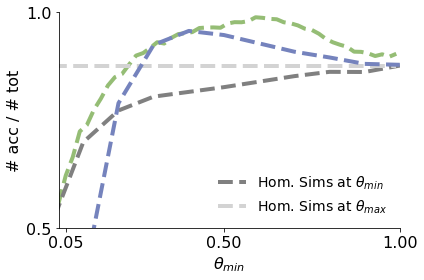

In [221]:
colors = sns.hls_palette(8, l = .6, s= .35); n = 15000

# Get maximum accurate point from dichotomous omniscient data
folder = baseFolder + '/Bern2Dense/'

folder2 = 'zMax_1_n' + str(n) + '/'
backgroundFile = folder + folder2 + 'background.mat'
current = sio.loadmat(backgroundFile)
gamma_list = current['gamma_array'][0,:]
th_minsDich = current['th_min_array'][0,:]
myData = data_Omni_Accs[::-1]

accs = []
for j in range(len(th_minsDich)):
    accs.append(max(myData[:,j]))

    
# Retreive rest of data

thetasHom = homDict2['thetas']
homAccs = [f/n for f in homDict2['allVsTheta'][n]['acc']]

ths = uniDict['thetas']
fracAccUni = [f/n for f in uniDict['allVsTheta'][n]['acc']]

# Plot
plt.plot(th_minsDich, accs, '--',label = None, color = colors[colorStart + 1],linewidth = lineWidth) 
plt.plot(thetasHom, homAccs, '--',label = 'Hom. Sims at ' + r'$\theta_{min}$', color = 'gray',  linewidth = lineWidth)
oneLine = np.ones(len(th_minsDich))*homAccs[-1]
plt.plot(th_minsDich,oneLine, '--', label = 'Hom. Sims at ' + r'$\theta_{max}$', color = 'lightgray',  linewidth = lineWidth)
plt.plot(ths,fracAccUni, '--',label = None, color = colors[colorStart + 4],linewidth = lineWidth)

plt.xlabel(r'$\theta_{min}$', fontsize = labelFontSize)
plt.ylabel('# acc / # tot', fontsize = labelFontSize)

plt.xticks(ticks = [0.05,.5,1],fontsize = labelFontSize)
plt.yticks(ticks = [.5,1],fontsize = labelFontSize)

plt.xlim(0.03,1)
plt.ylim(.5,1)

plt.legend(frameon = False, fontsize = labelFontSize-2)
plt.tight_layout()
sns.despine()

saveName = lateFolder + 'fracAccsMany.png'
plt.savefig(saveName,dpi = 300)
saveName= lateFolder + 'fracAccsMany.pdf'
plt.savefig(saveName,dpi = 300)

Figure 4, Panel b -- requires: homogeneous data, dichotomous omniscient data, uniform omniscient data
Shows the average number of agents deciding accurately divided by the total clique size (here, 15000 agents) as a function of average first decision time for homogeneous cliques with thresholds at thetaMin, homogeneous cliques with thresholds at thetaMax, omniscient cliques with thresholds drawn from a uniform distribution, and the best accuracy obtained for an omniscient dichotomous clique with the given expected first decision time (both gamma and thetaMin may vary along this line).

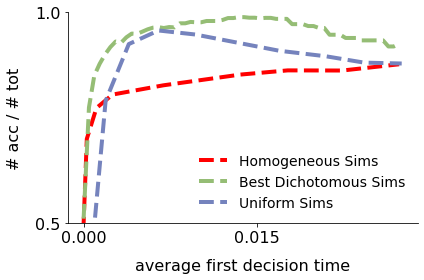

In [227]:
# local utility functions

def FDT_returnTh(time,pop):
    th = np.sqrt(time*4*np.log(pop))
    return th

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def frac_acc_bern_sims(thMin,gamma,n):
    folder = baseFolder + '/Bern2Dense/'
    
    folder2 = 'zMax_1_n' + str(n) + '/'
    backgroundFile = folder + folder2 + 'background.mat'
    current = sio.loadmat(backgroundFile)
    gammas = current['gamma_array']
    thmins = current['th_min_array']
    thIdx = find_nearest(thmins,thMin)
    gmIdx = find_nearest(gammas,gamma)
    
    th = thmins[0,thIdx]
    th_str = str(round(th,2)).replace('.','_')
    fileName = folder + folder2 + 'zMin_' + th_str + '.mat'
    
    current = sio.loadmat(fileName)
    accs = current['accs']
    fracAcc = accs[gmIdx,0,0]/n
    return fracAcc

def frac_acc_Max_bern_sims(time, n):
    fracList = []
    gamma_list = np.linspace(.001,.991,num = 50)
    theta_list = [FDT_returnTh(time, gamma*n) for gamma in gamma_list]
    
    for i in range(len(gamma_list)):
        fracList.append(frac_acc_bern_sims(theta_list[i], gamma_list[i], n))
    
    maxFrac = max(fracList)
    return maxFrac

colors = sns.hls_palette(8, l = .6, s= .35)

n = 15000


# Retreive and generate data
simHomoTimes = homDict2['allVsTheta'][n]['times']
simHomoAccs = [f/n for f in homDict2['allVsTheta'][n]['acc']]

    
times = np.linspace(simHomoTimes[0],simHomoTimes[-1], num = 60)
simBernMaxAccs = [frac_acc_Max_bern_sims(t,n) for t in times]

timesUni = uniDict['allVsTheta'][n]['times']
fracAccsUni = [f/n for f in uniDict['allVsTheta'][n]['acc']]


# Plot
colorStart = 1

plt.plot(simHomoTimes, simHomoAccs, '--', 
         label = 'Homogeneous Sims', color = 'red', lineWidth = lineWidth)
plt.plot(times, simBernMaxAccs, '--', 
         label = 'Best Dichotomous Sims',  lineWidth = lineWidth ,color = colors[colorStart + 1] ) 
plt.plot(timesUni,fracAccsUni,'--',label = 'Uniform Sims',color = colors[colorStart + 4],linewidth = lineWidth)

plt.xlabel('average first decision time', fontsize = labelFontSize, labelpad = padSize)
plt.ylabel('# acc / # tot', fontsize = labelFontSize, labelpad = padSize)

plt.xticks(ticks = [0,.015],fontsize = labelFontSize)
plt.yticks(ticks = [.5,1],fontsize = labelFontSize)
plt.ylim(.5,1)

plt.legend(frameon = False, fontsize = labelFontSize-2)
plt.tight_layout()
sns.despine()

saveName = lateFolder + 'Accuracy_and_Time_n15000.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + 'Accuracy_and_Time_n15000.pdf'
plt.savefig(saveName,dpi = 300)

## Supplement Figures

Figure S1 Panels a and b -- requires: p(x,t) data (not processed; generated in generate data m files)

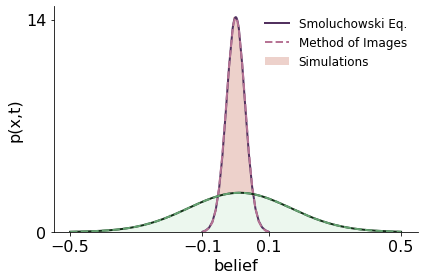

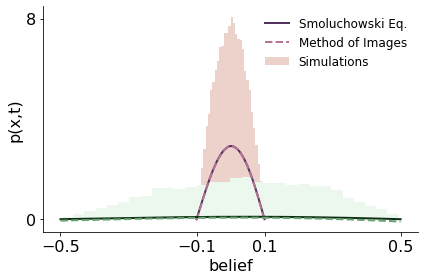

In [235]:
# S1, method of images
def getPsi(x,t,c):
    w = np.sqrt(4*np.pi*t)**(-1)*np.exp(-(x-c-t)**2/(4*t))
    return w

def getRho(x,t,th):
    r = getPsi(x,t,0) - np.exp(-th)*getPsi(x,t,-2*th) - np.exp(th)*getPsi(x,t,2*th)
    return r

# Utility functions

def getFiles(th,time,dtk):
    fileName = baseFolder + '/S1/'+ 'FPDEtime' + str(time).replace('.','_') + 'z' + str(th).replace('.','_') + '.mat'

    current = sio.loadmat(fileName)
    xMesh = current['xDense'][0]
    uMesh = current['uDense'][0]

    xThin = []; uThinFok = []

    i = 0
    while i <= len(xMesh):
        xThin.append(xMesh[i]); uThinFok.append(uMesh[i])
        i = i + 100

    uThinMoI = [getRho(x,time,th) for x in xMesh]

    fileName = earlyFolder + 'nK5dtK' + str(dtk) + 'time'+ str(time).replace('.','_') + 'z' + str(th).replace('.','_') + '.mat'
    current = sio.loadmat(fileName)
    xTest = current['xtest']
    xTest = xTest[xTest < th]
    xTest = xTest[xTest > -th]
    
    return(xMesh,uMesh,xTest,uThinMoI)

def makePicture(xMesh1,uMesh1,xTest1,uThinMoI1,
               xMesh2,uMesh2,xTest2,uThinMoI2,top):
    
    colors = sns.cubehelix_palette(8)
    plt.hist(xTest1, density = True,bins = 30, color = colors[0],label = 'Simulations')
    plt.plot(xMesh1,uMesh1, label = 'Smoluchowski Eq.', linewidth = lineWidth-2,color = colors[6])
    plt.plot(xMesh1,uThinMoI1, '--',label = 'Method of Images', linewidth = lineWidth-2,color = colors[3])

    colors = sns.cubehelix_palette(8, start=2, rot=0,light = .95,dark = 0)
    plt.hist(xTest2, density = True,bins = 30, color = colors[0],label = None)
    plt.plot(xMesh2,uMesh2, label = None, linewidth = lineWidth-2,color = colors[6])
    plt.plot(xMesh2,uThinMoI2, '--',label = None, linewidth = lineWidth-2,color = colors[3])

    plt.legend(frameon = False,fontsize = labelFontSize -4)
    plt.yticks(ticks = [0,top],fontsize = labelFontSize)
    plt.xticks(ticks = [-.5,-.1,.1,.5],fontsize = labelFontSize)
    plt.xlabel('belief',fontsize=labelFontSize)
    plt.ylabel('p(x,t)',fontsize = labelFontSize)
    plt.tight_layout()
    sns.despine()

    saveName = lateFolder + 'S1_th_' + str(th)  + '.png'
    plt.savefig(saveName, dpi = 300)
    saveName = lateFolder + 'S1_th_' + str(th) +'.pdf'
    plt.savefig(saveName, dpi = 300)

# Potential (data exists; these parameters may be used)
# .1, .0004023, 23
# .5, .01006, 21

# Currently used: (appropriate first decision time)
#th = .1; time = .0004; dtk = 22
#th = .5; time = .012; dtk = 18

# Time large example (also currently used)
#th = .5; time = .3; dtk = 18
# = .1; time = .0012; dtk = 18


mrg = getFiles(.1,.0004,22)
xMesh1 = mrg[0]; uMesh1 = mrg[1]; xTest1 = mrg[2]; uThinMoi1 = mrg[3]

mrg = getFiles(.5,.012,18)
xMesh2 = mrg[0]; uMesh2 = mrg[1]; xTest2 = mrg[2]; uThinMoI2 = mrg[3]

fig1,ax1 = plt.subplots()
makePicture(xMesh1,uMesh1,xTest1,uThinMoi1,xMesh2,uMesh2,xTest2,uThinMoI2,14)


mrg = getFiles(.1,.005,18)
xMesh1 = mrg[0]; uMesh1 = mrg[1]; xTest1 = mrg[2]; uThinMoi1 = mrg[3]

mrg = getFiles(.5,.3,18)
xMesh2 = mrg[0]; uMesh2 = mrg[1]; xTest2 = mrg[2]; uThinMoI2 = mrg[3]

fig2,ax2 = plt.subplots()
makePicture(xMesh1,uMesh1,xTest1,uThinMoi1,xMesh2,uMesh2,xTest2,uThinMoI2,8)

Figure S2 -- requires: homogeneous data
Shows distribution of first decision times for homogeneous cliques with various sizes and thresholds.

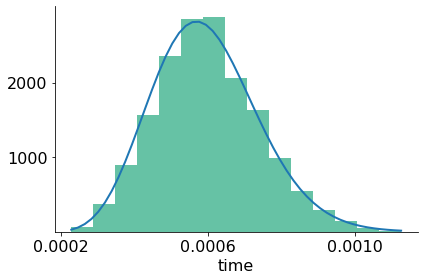

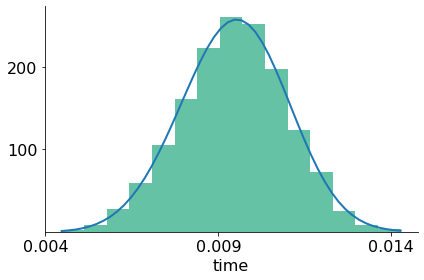

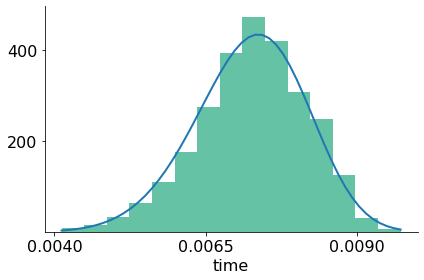

In [248]:
# Local analytic functions
import math

def phi(t,th):
    
    phi = .5*(math.erfc((th-t)/np.sqrt(4*t))*(1+np.exp(-th)) + math.erfc((th+t)/np.sqrt(4*t))*(1+np.exp(th)))
    return phi

def rho(t,th):
    rho = (th/np.sqrt(4*np.pi*t**3))*(np.exp(-(th-t)**2/(4*t)) + np.exp(-(th+t)**2/(4*t)))
    return rho

def rho_n(n,t,th):
    rhon = n * np.exp(-(n-1)*phi(t,th))*rho(t,th)
    return rhon

#local utility functions

def getFiles(th,n):

    earlyFolder = baseFolder + 'SelfHomo_Paper/'
    midFolder = earlyFolder + 'zMin_' + str(th).replace('.','_') + '_zMax_' + str(th).replace('.','_') + '/'
    times = []

    batch = 1
    fileName = midFolder + 'Raw_n' + str(n) + '_batch_' + str(batch) + '.mat'

    while (os.path.exists(fileName) and batch < 30):
        
        current = sio.loadmat(fileName)
        t = current['times']
        batchSize = int(current['batchSize'][0])
        FDs = current['FDI']
      
        for i in range(batchSize):
            times.append(t[i][0])
        batch = batch + 1
        fileName = midFolder + 'Raw_n' + str(n) + '_batch_' + str(batch) + '.mat'
  
    start = min(times); end = max(times)
    tMesh = np.linspace(start,end)
    rhos = [rho_n(n,t,th) for t in tMesh]
    return(times,tMesh,rhos)

def plotThings(times,tMesh,rhos,ytick = None,xtick = None):
    
    colors = sns.color_palette('Set2')
    plt.hist(times, density = True,bins = 15, color = colors[0],label = None)

    plt.plot(tMesh,rhos, label = r'$\rho(t)$',linewidth = lineWidth -2)
    #plt.legend(frameon = False, fontsize = labelFontSize -2)
    plt.yticks(ticks = ytick,fontsize = labelFontSize)
    plt.xticks(ticks = xtick,fontsize = labelFontSize)
    plt.xlabel('time',fontsize=labelFontSize)
    #plt.ylabel(fontsize = labelFontSize)
    plt.tight_layout()
    sns.despine()

    saveName = lateFolder + 'S2_th_' + str(th) + '_n_' + str(n) + '.png'
    plt.savefig(saveName, dpi = 300)
    saveName = lateFolder + 'S2_th_' + str(th) + '_n_' + str(n) + '.pdf'
    plt.savefig(saveName, dpi = 300)
    
fig1,ax1 = plt.subplots()
th = .1; n = 100
mrg = getFiles(th,n)
plotThings(mrg[0],mrg[1],mrg[2],ytick = [1000,2000],xtick = [.0002,.0006,.001])

fig2, ax2 = plt.subplots()
th = .5; n = 1200
mrg = getFiles(th,n)
plotThings(mrg[0],mrg[1],mrg[2],ytick = [100,200],xtick = [.004,.009,.014])

fig3,ax3 = plt.subplots()
th = .5; n = 10000
mrg = getFiles(th,n)
plotThings(mrg[0],mrg[1],mrg[2],ytick = [200,400],xtick = [.004,.0065,.009])

Figure S3, Panel a -- requires: homogeneous data
Shows graph for the variance in the size of the first wave, conditioned on an accurate first decision.

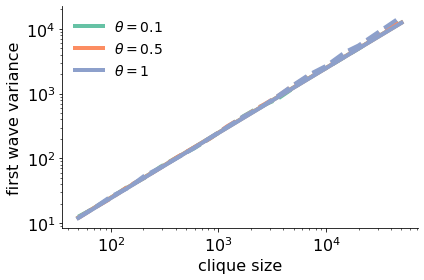

In [253]:
# local analytic function
def firstVar_hom(th,n):
    time = th**2/(4*np.log(n))
    one= quad(MoI,0,th,args = (time))
    two = quad(MoI,-th,th,args = (time))
    pA = one[0]/two[0]
    aa = (n-1)*pA*(1-pA)
    
    return aa


# Retrieve data and plot
thlist = homDict['thetas']
n_array = homDict['ns']
colors = sns.color_palette('Set2')
thId = (0,2,4)
for i in range(len(thId)):
    th = thlist[thId[i]]
    thstr = r'$\theta = $' + str(th)
    ana = [firstVar_hom(th,n) for n in n_array]
    right = homDict['firstWaveRVarVsN'][i]
    superBasicPlot(n_array,ana,right,colori = colors[i],labeli = thstr)
    
plt.xticks(fontsize = labelFontSize)
plt.xscale('log')
plt.yticks(ticks = [1500,3000],fontsize = labelFontSize)
plt.yscale('log')
plt.xlabel('clique size',fontsize=labelFontSize)
plt.ylabel('first wave variance',fontsize = labelFontSize)
plt.tight_layout()
sns.despine()

saveName = lateFolder + 'firstVariance.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + 'firstVariance.pdf'
plt.savefig(saveName, dpi = 300)

Figure S3, Panel b -- requires: homogeneous data
Shows graph for the variance in the size of the first wave for homogeneous cliques of size n = 15000 with various thresholds.

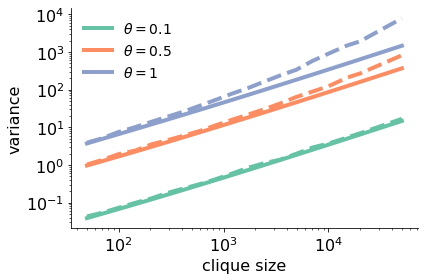

In [305]:
# local analytic function
def incVar_hom(th,n):
    time = th**2/(4*np.log(n))
    one= quad(MoI,0,th,args = (time))
    two = quad(MoI,-th,th,args = (time))
    pA = one[0]/two[0]
    aa = (n-1)*pA*(1-pA)
    rp = RpMoI(time,th)
    cc = 4*rp**2*aa
    return cc

# Retrieve data and plot
thlist = homDict['thetas']
n_array = homDict['ns']
colors = sns.color_palette('Set2')
thId = (2,5,9)
thId = (0,2,4)
for i in range(len(thId)):
    th = thlist[thId[i]]
    thstr = r'$\theta = $' + str(thlist[thId[i]])
    ana = [incVar_hom(th,n) for n in n_array]
    right = homDict['incVarVsN'][int(thId[i])]
    superBasicPlot(n_array,ana,right,colori = colors[i],labeli = thstr)
    
plt.xticks(fontsize = labelFontSize)
plt.xscale('log')
plt.yticks(ticks = [1500,3000],fontsize = labelFontSize)
plt.yscale('log')
plt.xlabel('clique size',fontsize=labelFontSize)
plt.ylabel('variance',fontsize = labelFontSize)
plt.tight_layout()
sns.despine()

saveName = lateFolder + 'incrementVariance.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + 'incrementVariance.pdf'
plt.savefig(saveName, dpi = 300)

Figure S4 -- requires: dichotomous consensus bias data
Shows graph for size of first wave conditioned on an accurate first decision for a dichotomous clique with 15000 agents under consensus bias social updating for various values of gamma.

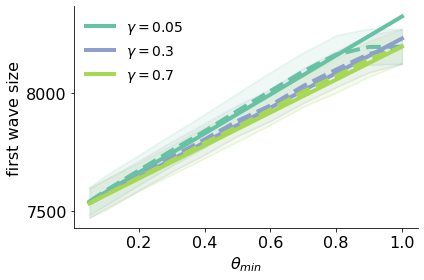

In [263]:
# local analytic function
def getFirstWaveDich(th,n,gamma,FD = 1):
    if FD == 1: w = ((n-1)/2)*(1 + th/np.sqrt(4*np.pi*np.log(gamma*n)))
    else: w = ((n-1)/2)*(1 - th/np.sqrt(4*np.pi*np.log(gamma*n)))
    return w

# Retrieve data and plot
gammas = (.05,.3,.7); n = 15000
colors = sns.color_palette('Set2')
for i in range(len(gammas)):
    mrg = dichCBdicts[i]
    gammaLabel = r'$\gamma = $' + str(gammas[i])
    thetas = mrg['thetas']
    ana = [getFirstWaveDich(th,n,gammas[i]) for th in thetas]
    fw = mrg['allVsTheta'][n]['fwR']
    fwLow =mrg['allVsTheta'][n]['lowFwR']; fwHigh = mrg['allVsTheta'][n]['highFwR']
    
    basicPlot(thetas,ana,fw,fwLow,fwHigh,colori = colors[i*2],labeli = gammaLabel)

    
plt.yticks(ticks = [7500,8000],fontsize = labelFontSize)
plt.xticks(fontsize = labelFontSize)
plt.xlabel(r'$\theta_{min}$',fontsize=labelFontSize)
plt.ylabel('first wave size',fontsize = labelFontSize)
plt.tight_layout()
sns.despine()

saveName = lateFolder + 'firstWaveDichConBias.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + 'firstWaveDichConBias.pdf'
plt.savefig(saveName, dpi = 300)
    

Figure S5 -- requires: dichotomous omniscient data (non-heatmap)
Shows graph for size of first wave as a function of thetaMin for various gamma (fraction of clique at lower threshold) for a dichotomous omniscient clique of size n = 15000.

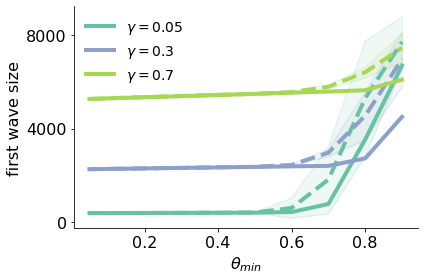

In [320]:
# local analytic function

def firstWave(folder,gamma,n,thmin,thmax = 1):
    interFolder = folder + '/gamma_' + str(gamma).replace('.','_') + '/'
    
    mrg = getPk(interFolder,n,thmin,thmax)
    pmin = mrg[0]; pmax = mrg[2]
    
    sq = thmin/np.sqrt(4*np.pi*np.log(gamma*n))
    aplus = pmin*((((gamma*n)-1)/2)*(1+sq)) + pmax*(gamma*n + ((n-gamma*n-1)/2)*(1+sq))
    pmin = mrg[1]; pmax = mrg[3]
    aminus = pmin*((((gamma*n)-1)/2)*(1-sq)) + pmax*(gamma*n + ((n-gamma*n-1)/2)*(1-sq))
    return (aplus,aminus)

# Retrieve data and plot
gammas = (.05,.3,.7); n = 15000
colors = sns.color_palette('Set2')
for i in range(len(gammas)):
    mrg = dichOmniDicts[i]
    gammaLabel = r'$\gamma = $' + str(gammas[i])
    thetas = mrg['thetas']
    ana = [firstWave(baseFolder + '/Dich/',gammas[i],n,th)[0] for th in thetas]
    fw = mrg['allVsTheta'][n]['fwR']
    fwLow =mrg['allVsTheta'][n]['lowFwR']; fwHigh = mrg['allVsTheta'][n]['highFwR']
    
    basicPlot(thetas,ana,fw,fwLow,fwHigh,colori = colors[i*2],labeli = gammaLabel)

    
plt.yticks(ticks = [0,4000,8000],fontsize = labelFontSize)
plt.xticks(fontsize = labelFontSize)
plt.xlabel(r'$\theta_{min}$',fontsize=labelFontSize)
plt.ylabel('first wave size',fontsize = labelFontSize)
plt.tight_layout()
sns.despine()

saveName = lateFolder + 'firstWaveDichOmni.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + 'firstWaveDichOmni.pdf'
plt.savefig(saveName, dpi = 300)

Figure S6 -- requires: dichotomous omniscient data (non-heatmap)
Shows graph for size of increment to the second wave as a function of thetaMin for various gamma.

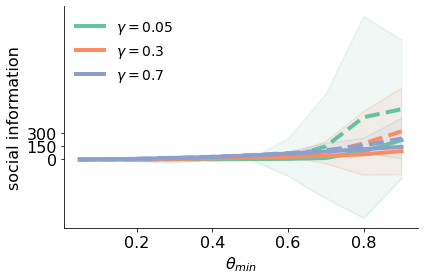

In [324]:
# local analytic function

def socialUpdate(folder,gamma,n,thmin,thmax = 1):
    interFolder = folder + '/gamma_' + str(gamma).replace('.','_') + '/'
    
    mrg = getPk(interFolder,n,thmin,thmax)
    pmin = mrg[0]; pmax = mrg[2]
    
    sq = 1/(2*np.pi*np.log(gamma*n))
    aplus = pmin*(thmin**2*gamma*n*sq) + pmax*(thmin**2*(1-gamma)*n*sq)
    
    aplusPrime = thmin**2*gamma*n*sq
    delo = thmax-thmin
    num =  ((gamma*n)**(-(delo/thmin)**2))/delo - ((gamma*n)**(-(thmax/thmin)**2))/thmax
    den =  np.sqrt(np.pi*np.log(gamma*n))/thmin - ((gamma*n)**(-(thmax/thmin)**2))/thmax
    T = thmin**2/np.sqrt(4*np.pi*np.log(gamma*n))
    nr = 2*np.sqrt(T/np.pi)
    num2 = nr*np.exp(-delo**2/(4*T))/delo - nr*np.exp(-thmax**2/(4*T))/thmax
    den2 = 1- nr*np.exp(-thmax**2/(4*T))/thmax
    #aplus2 = pmin*((((gamma*n)-1)/2)*(1+sq)+ ((1-gamma)*n/2)*num2/den2) + pmax*(gamma*n + ((n-gamma*n-1)/2)*(1+sq))
    aplus2 = aplusPrime + (((1-gamma)*n/2)*(1-pmin*num2/den2))*(thmax/np.sqrt(np.pi*np.log(gamma*n)))
    pmin = mrg[1]; pmax = mrg[3]
    aminus = pmin*(thmin**2*gamma*n*sq) + pmax*(thmin**2*(1-gamma)*n*sq)
    return (aplus,aminus,aplusPrime,aplus2)


# Retrieve data and plot
gammas = (.05,.3,.7); n = 15000
colors = sns.color_palette('Set2')
for i in range(len(gammas)):
    mrg = dichOmniDicts[i]
    gammaLabel = r'$\gamma = $' + str(gammas[i])
    thetas = mrg['thetas']
    ana = [socialUpdate(baseFolder + '/Dich/',gammas[i],n,th)[0] for th in thetas]
    rp = mrg['allVsTheta'][n]['inc']
    rpLow =mrg['allVsTheta'][n]['lowInc']; rpHigh = mrg['allVsTheta'][n]['highInc']
    
    basicPlot(thetas,ana,rp,rpLow,rpHigh,colori = colors[i],labeli = gammaLabel)
    
plt.yticks(ticks = [0,150,300],fontsize = labelFontSize)
plt.xticks(fontsize = labelFontSize)
plt.xlabel(r'$\theta_{min}$',fontsize=labelFontSize)
plt.ylabel('social information',fontsize = labelFontSize)
plt.tight_layout()
sns.despine()

saveName = lateFolder + 'socialUpdateDichOmniFDA.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + 'socialUpdateDichOmniFDA.pdf'
plt.savefig(saveName, dpi = 300)

Figure S7 -- requires: uniform consensus bias data
Shows expected first decision time for a clique with thresholds drawn from a uniform distribution as a function of thetaMin

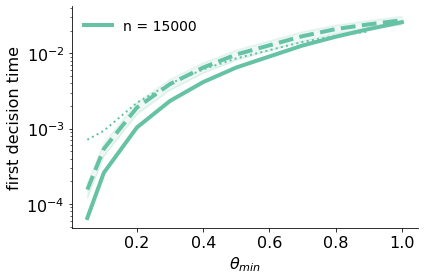

In [283]:
# local analytic functions

def getFDTUni(th,n):
    t = th**2/(4*np.log(n))
    return t

def getFDTUniOld(thmin,n):
    thmax = 1
    t = thmin**2/(2*np.log((2*thmin**5*n**2)/(27*(thmax-thmin)**2)))
    return t



# Retrieve data and plot
thetas = uniDict['thetas']
n = 15000

ana1 = [getFDTUni(th,n) for th in thetas]
ana2 = [getFDTUniOld(th,n) for th in thetas[0:-1]]

mrg = uniDict['allVsTheta'][n]
times = mrg['times']; timesLow = mrg['lowTimes']; timesHigh = mrg['highTimes']

basicPlot(thetas,ana1,times,timesLow,timesHigh,colori = colors[0],labeli = 'n = ' + str(n))
plt.plot(thetas[0:-1],ana2,':',label=None,color = colors[0],linewidth = 2)

plt.legend(frameon=False, fontsize = labelFontSize-2)
plt.yticks(ticks = [0,.01,.02],fontsize = labelFontSize)
plt.xticks(fontsize = labelFontSize)
plt.yscale('log')
#plt.ylim(0.017,.025)
plt.xlabel(r'$\theta_{min}$',fontsize=labelFontSize)
plt.ylabel('first decision time',fontsize = labelFontSize)
plt.tight_layout()
sns.despine()

saveName = lateFolder + 'uniFDT.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + 'uniFDT.pdf'
plt.savefig(saveName, dpi = 300)

Figure S8 -- requires: uniform consensus bias data

In [1]:
# local analytic function
def getCUniSelf(th,n):
    c = (n*th**2)/(2*np.pi*np.log(n))
    return c


# Retrieve data and plot
n_array = (5000,10000)
thetas = uniCBdict['thetas']
colors = sns.color_palette('Set2')
for i in range(len(n_array)):
    n = n_array[i]
    mrg = uniCBdict['allVsTheta'][n]
    ana = [getCUniSelf(th,n) for th in thetas]
    fw = mrg['inc']; fwLow = mrg['lowInc']; fwHigh = mrg['highInc']
    
    basicPlot(thetas,ana,fw,fwLow,fwHigh,colori = colors[i],labeli = 'n = ' + str(n))

plt.yticks(ticks = [100,200],fontsize = labelFontSize)
plt.xticks(fontsize = labelFontSize)
#plt.xscale('log')
#plt.ylim(0,.035)
plt.xlabel('clique size',fontsize=labelFontSize)
plt.ylabel('social increment',fontsize = labelFontSize)
plt.tight_layout()
sns.despine()

saveName = lateFolder + 'uniSelfSocial.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + 'uniSelfSocial.pdf'
plt.savefig(saveName, dpi = 300)

NameError: name 'uniCBdict' is not defined

Figure S9, Panel a -- requires: homogeneous data, dichotomous omniscient heatmap data, uniform omniscient data, inclined shed omniscient data, declined shed omniscient data, tent omniscient data
Shows fraction of clique deciding accurately (average number of agents who make a correct decision by the end of the second wave divided by total number of agents in the clique) for cliques of size 15000 with thresholds drawn from the various distributions as a function of thetaMin.
An extension of main paper Figure 4, Panel a.

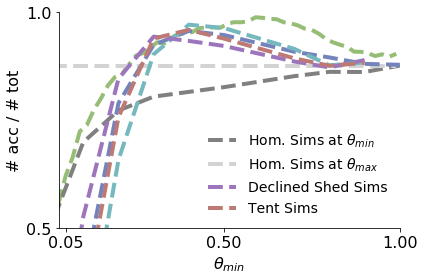

In [287]:
colors = sns.hls_palette(8, l = .6, s= .35); n = 15000

# Get maximum accurate point from dichotomous omniscient data
folder = baseFolder + '/Bern2Dense/'

folder2 = 'zMax_1_n' + str(n) + '/'
backgroundFile = folder + folder2 + 'background.mat'
current = sio.loadmat(backgroundFile)
gamma_list = current['gamma_array'][0,:]
th_minsDich = current['th_min_array'][0,:]
myData = data_Omni_Accs[::-1]

accs = []
for j in range(len(th_minsDich)):
    accs.append(max(myData[:,j]))

    
# Retreive rest of data

thetasHom = homDict2['thetas']
homAccs = [f/n for f in homDict2['allVsTheta'][n]['acc']]

ths = uniDict['thetas']
fracAccUni = [f/n for f in uniDict['allVsTheta'][n]['acc']]
ths2 = incShedDict['thetas']
fracAccIncShed = [f/n for f in incShedDict['allVsTheta'][n]['acc']]
fracAccDecShed = [f/n for f in decShedDict['allVsTheta'][n]['acc']]
fracAccTent = [f/n for f in tentDict['allVsTheta'][n]['acc']]

# Plot
plt.plot(th_minsDich, accs, '--',label = None, color = colors[colorStart + 1],linewidth = lineWidth) 
plt.plot(thetasHom, homAccs, '--',label = 'Hom. Sims at ' + r'$\theta_{min}$', color = 'gray',  linewidth = lineWidth)
oneLine = np.ones(len(th_minsDich))*homAccs[-1]
plt.plot(th_minsDich,oneLine, '--', label = 'Hom. Sims at ' + r'$\theta_{max}$', color = 'lightgray',  linewidth = lineWidth)
plt.plot(ths,fracAccUni, '--',label = None, color = colors[colorStart + 4],linewidth = lineWidth)

plt.plot(ths2,fracAccIncShed,'--',label = None, color = colors[colorStart +3],linewidth = lineWidth)#
plt.plot(ths2,fracAccDecShed,'--',label = 'Declined Shed Sims', color = colors[colorStart + 5],linewidth = lineWidth)#
plt.plot(ths2,fracAccTent,'--',label = 'Tent Sims', color = colors[colorStart - 1],linewidth = lineWidth)#

plt.xlabel(r'$\theta_{min}$', fontsize = labelFontSize)
plt.ylabel('# acc / # tot', fontsize = labelFontSize)

plt.xticks(ticks = [0.05,.5,1],fontsize = labelFontSize)
plt.yticks(ticks = [.5,1],fontsize = labelFontSize)

plt.xlim(0.03,1)
plt.ylim(.5,1)

plt.legend(frameon = False, fontsize = labelFontSize-2)
plt.tight_layout()
sns.despine()

saveName = lateFolder + 'fracAccsMany_ext.png'
plt.savefig(saveName,dpi = 300)
saveName= lateFolder + 'fracAccsMany_ext.pdf'
plt.savefig(saveName,dpi = 300)

Figure S9, Panel b --requires: homogeneous data, dichotomous omniscient heatmap data, uniform omniscient data, inclined shed omniscient data, declined shed omniscient data, tent omniscient data
Shows fraction of clique deciding accurately (average number of agents who make a correct decision by the end of the second wave divided by total number of agents in the clique) for cliques of size 15000 with thresholds drawn from the various distributions as a function of expected first decision time.
An extension of main paper Figure 4, Panel b.

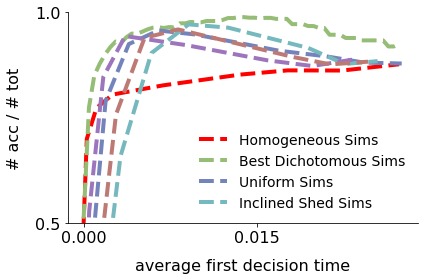

In [288]:
# local utility functions

def FDT_returnTh(time,pop):
    th = np.sqrt(time*4*np.log(pop))
    return th

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def frac_acc_bern_sims(thMin,gamma,n):
    folder = baseFolder + '/Bern2Dense/'
    
    folder2 = 'zMax_1_n' + str(n) + '/'
    backgroundFile = folder + folder2 + 'background.mat'
    current = sio.loadmat(backgroundFile)
    gammas = current['gamma_array']
    thmins = current['th_min_array']
    thIdx = find_nearest(thmins,thMin)
    gmIdx = find_nearest(gammas,gamma)
    
    th = thmins[0,thIdx]
    th_str = str(round(th,2)).replace('.','_')
    fileName = folder + folder2 + 'zMin_' + th_str + '.mat'
    
    current = sio.loadmat(fileName)
    accs = current['accs']
    fracAcc = accs[gmIdx,0,0]/n
    return fracAcc

def frac_acc_Max_bern_sims(time, n):
    fracList = []
    gamma_list = np.linspace(.001,.991,num = 50)
    theta_list = [FDT_returnTh(time, gamma*n) for gamma in gamma_list]
    
    for i in range(len(gamma_list)):
        fracList.append(frac_acc_bern_sims(theta_list[i], gamma_list[i], n))
    
    maxFrac = max(fracList)
    return maxFrac

colors = sns.hls_palette(8, l = .6, s= .35)

n = 15000


# Retreive and generate data
simHomoTimes = homDict2['allVsTheta'][n]['times']
simHomoAccs = [f/n for f in homDict2['allVsTheta'][n]['acc']]

    
times = np.linspace(simHomoTimes[0],simHomoTimes[-1], num = 60)
simBernMaxAccs = [frac_acc_Max_bern_sims(t,n) for t in times]

timesUni = uniDict['allVsTheta'][n]['times']
fracAccsUni = [f/n for f in uniDict['allVsTheta'][n]['acc']]
timesIncShed = incShedDict['allVsTheta'][n]['times']
fracAccIncShed = [f/n for f in incShedDict['allVsTheta'][n]['acc']]
timesDecShed = decShedDict['allVsTheta'][n]['times']
fracAccDecShed = [f/n for f in decShedDict['allVsTheta'][n]['acc']]
timesTent = tentDict['allVsTheta'][n]['times']
fracAccTent = [f/n for f in tentDict['allVsTheta'][n]['acc']]


# Plot
colorStart = 1

plt.plot(simHomoTimes, simHomoAccs, '--', 
         label = 'Homogeneous Sims', color = 'red', lineWidth = lineWidth)
plt.plot(times, simBernMaxAccs, '--', 
         label = 'Best Dichotomous Sims',  lineWidth = lineWidth ,color = colors[colorStart + 1] ) 
plt.plot(timesUni,fracAccsUni,'--',label = 'Uniform Sims',color = colors[colorStart + 4],linewidth = lineWidth)


plt.plot(timesIncShed,fracAccIncShed,'--', label= 'Inclined Shed Sims',color = colors[colorStart + 3],linewidth = lineWidth)#
plt.plot(timesDecShed,fracAccDecShed,'--',label = None,color = colors[colorStart + 5],linewidth = lineWidth)#
plt.plot(timesTent,fracAccTent,'--',label = None,color = colors[colorStart -1],linewidth = lineWidth)#

plt.xlabel('average first decision time', fontsize = labelFontSize, labelpad = padSize)
plt.ylabel('# acc / # tot', fontsize = labelFontSize, labelpad = padSize)

plt.xticks(ticks = [0,.015],fontsize = labelFontSize)
plt.yticks(ticks = [.5,1],fontsize = labelFontSize)
plt.ylim(.5,1)

plt.legend(frameon = False, fontsize = labelFontSize-2)
plt.tight_layout()
sns.despine()

saveName = lateFolder + 'Accuracy_and_Time_n15000_ext.png'
plt.savefig(saveName, dpi = 300)
saveName = lateFolder + 'Accuracy_and_Time_n15000_ext.pdf'
plt.savefig(saveName,dpi = 300)